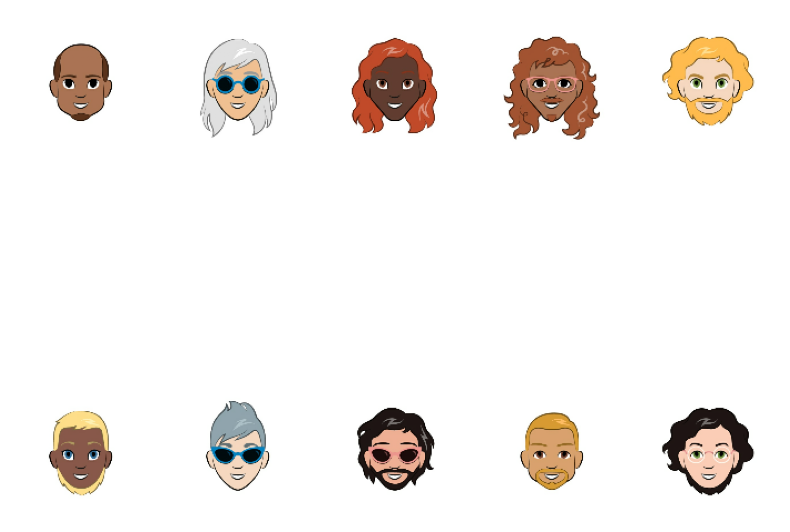

In [55]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

def load_data(data_dir):
    def load_image(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (128, 128))
        image = tf.cast(image, tf.float32) / 255.0 * 2 - 1  # نرمال‌سازی به بازه [-1, 1]
        return image

    image_paths = []
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        for filename in os.listdir(folder_path):
            image_paths.append(os.path.join(folder_path, filename))
            break  # Load only one image from each subfolder

    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(10).prefetch(tf.data.AUTOTUNE)
    return dataset

def display_sample_images(dataset):
    sample_images = []
    for images in dataset.take(1):
        sample_images = images[:10]
    
    rows = (10 + 1) // 5  # Calculate the number of rows needed
    fig, axes = plt.subplots(rows, 5, figsize=(8, 5 * rows))
    
    for i, img in enumerate(sample_images):
        row, col = divmod(i, 5)
        axes[row, col].imshow((img + 1) / 2.0)  # Convert images back to [0, 1] range
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

data_dir = '/kaggle/input/cartoon-faces-googles-cartoon-set/cartoonset100k_jpg'
dataset = load_data(data_dir)
display_sample_images(dataset)


/tmp/ipykernel_36/743355531.py:140: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave('model_progress.gif', [imageio.imread(img.data) for img in generated_images], fps=2)


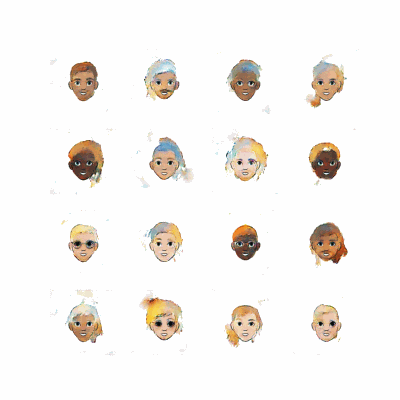

In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from IPython.display import Image, display
import imageio
import matplotlib.pyplot as plt
import io
from IPython.display import clear_output, display, Image

def load_data(data_dir):
    def load_image(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (128, 128))
        image = tf.cast(image, tf.float32) / 255.0 * 2 - 1  # نرمال‌سازی به بازه [-1, 1]
        return image

    image_paths = []
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        for filename in os.listdir(folder_path):
            image_paths.append(os.path.join(folder_path, filename))

    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset

def make_generator():
    model = Sequential([
        Dense(16 * 16 * 256, input_shape=(100,), activation='relu'),
        Reshape((16, 16, 256)),
        Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', activation='relu'),
        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
        Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', activation='relu'),
        Conv2D(3, (5, 5), padding='same', activation='tanh')
    ])
    return model

def make_discriminator():
    model = Sequential([
        Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=(128, 128, 3)),
        LeakyReLU(0.2),
        Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(0.2),
        Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(0.2),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

@tf.function
def train_step(images, generator, discriminator):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, 100])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)
        disc_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output) + \
                    tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2.0)  # تبدیل به بازه [0, 1]
        plt.axis('off')
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return buf

def train(dataset, epochs):
    images = []
    test_input = tf.random.normal([16, 100])
    
    initial_noise = test_input.numpy()
    np.save('initial_noise.npy', initial_noise)
    
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, generator, discriminator)
        
        print(f'Epoch {epoch+1}/{epochs}, G_loss: {gen_loss:.4f}, D_loss: {disc_loss:.4f}')
        
        # تولید و ذخیره تصاویر نمونه
        if (epoch + 1) % 5 == 0 or epoch == 0:
            img_buf = generate_and_save_images(generator, epoch + 1, test_input)
            images.append(Image(data=img_buf.getvalue()))
            
            display(images[-1])
            clear_output(wait=True)
    
    return images

generator = make_generator()
discriminator = make_discriminator()

generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

data_dir = '/kaggle/input/cartoon-faces-googles-cartoon-set/cartoonset100k_jpg'
dataset = load_data(data_dir)

generated_images = train(dataset, epochs=30)

imageio.mimsave('model_progress.gif', [imageio.imread(img.data) for img in generated_images], fps=2)

display(Image(filename='model_progress.gif'))

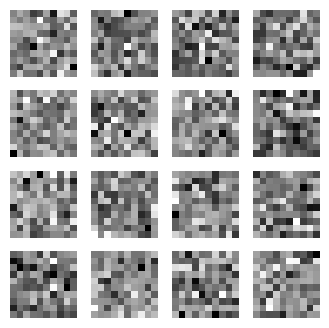

In [12]:
# نمایش نویز اولیه
initial_noise = np.load('initial_noise.npy')
fig = plt.figure(figsize=(4, 4))
for i in range(initial_noise.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(initial_noise[i].reshape(10, 10), cmap='gray')  
    plt.axis('off')
plt.show()

/tmp/ipykernel_36/3755257665.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  axes[row, col].imshow(imageio.imread(img.data))


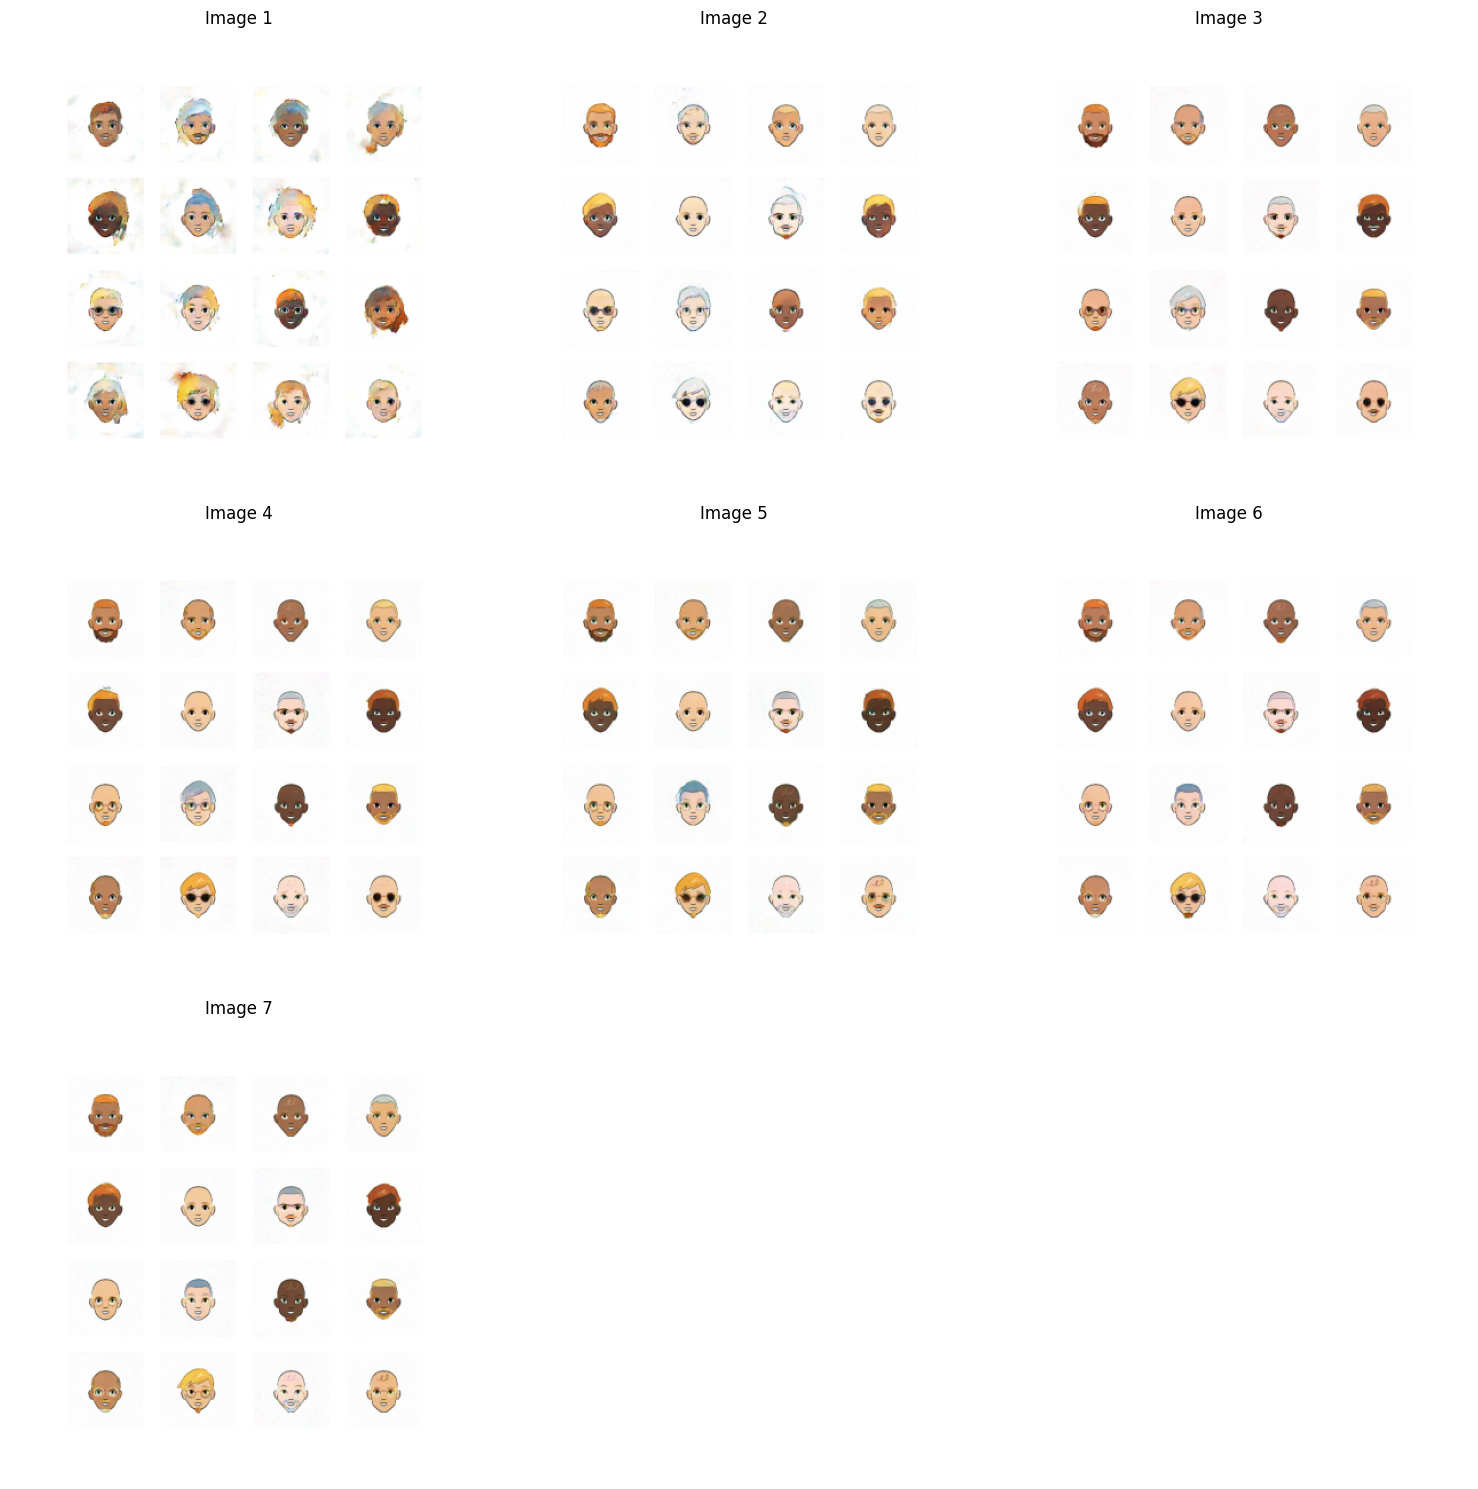

In [24]:
def display_all_generated_images(images):
    num_images = len(images)
    rows = (num_images + 2) // 3  # Calculate the number of rows needed
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    
    for i, img in enumerate(images):
        row, col = divmod(i, 3)
        axes[row, col].imshow(imageio.imread(img.data))
        axes[row, col].set_title(f'Image {i + 1}')
        axes[row, col].axis('off')
    
    # Hide any empty subplots
    for j in range(num_images, rows * 3):
        row, col = divmod(j, 3)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display all generated images
display_all_generated_images(generated_images)

In [26]:
import zipfile
import os

# Directory to save the images
output_dir = 'generated_images'
os.makedirs(output_dir, exist_ok=True)

# Save each generated image to the directory
for i, img in enumerate(generated_images):
    img_path = os.path.join(output_dir, f'image_{i+1}.png')
    with open(img_path, 'wb') as f:
        f.write(img.data)

# Create a zip file
zip_filename = 'generated_images.zip'
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_dir))

print(f'Images have been zipped into {zip_filename}')

Images have been zipped into generated_images.zip
